In [1]:
import os
import joblib
import zipfile
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
RAW_DATA_PATH = "../../data/raw/"
PROCESSED_DATA_PATH = "../../data/processed/"

In [3]:
def dump(value, filename):
    if value is not None and filename is not None:
        joblib.dump(value=value, filename=filename)
        
    else:
        raise Exception("Please provide a valid path".capitalize())
    
def load(filename):
    if filename is not None:
        return joblib.load(filename=filename)
    else: 
        raise Exception("Please provide a valid path".capitalize())
    
def clean():
    if os.path.exists(RAW_DATA_PATH):
        directory = os.listdir(RAW_DATA_PATH)

        if os.path.isdir(RAW_DATA_PATH):
            os.system("rm -rf {}".format(os.path.join(RAW_DATA_PATH, directory[0])))
            print("done")
        
        else:
            raise Exception("Please provide a valid path".capitalize())
    else:
        raise Exception("Please provide a valid path".capitalize())
    
    if os.path.exists(PROCESSED_DATA_PATH):
        
        for file in os.listdir(PROCESSED_DATA_PATH):
            os.remove(os.path.join(PROCESSED_DATA_PATH, file))
        
    else:
        raise Exception("Please provide a valid path".capitalize())

In [4]:
class Loader(DataLoader):
    def __init__(self, image_path = None, batch_size = 16, image_size = 64, split_ratio = 0.25):
        self.image_path = image_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.split_ratio = split_ratio

        self.clean_images = list()
        self.noise_images = list()

    def unzip_folder(self):

        try:
            clean()
        except Exception as e:
            print("The exception is: {}".format(e))
            
        if os.path.exists(RAW_DATA_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_DATA_PATH,))
        else:
            raise Exception("Please provide a valid path".capitalize())

    def image_transforms(self):
        return transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def image_split(self, **kwargs):
        return train_test_split(
            kwargs["noise_images"], kwargs["clean_images"], test_size=self.split_ratio, random_state=42,
        )

    def create_dataloader(self):

        if os.path.exists(RAW_DATA_PATH):
            dataset = os.listdir(RAW_DATA_PATH)[0]

            clean_images = os.path.join(RAW_DATA_PATH, dataset, "clean_images")
            noise_images = os.path.join(RAW_DATA_PATH, dataset, "noisy_images")

            for image in os.listdir(clean_images):
                clean_image_path = os.path.join(clean_images, image)

                if image in os.listdir(noise_images):
                    noise_image_path = os.path.join(noise_images, image)
                else:
                    continue

                self.clean_images.append(
                    self.image_transforms()(
                        Image.fromarray(cv2.imread(clean_image_path))))

                self.noise_images.append(
                    self.image_transforms()(
                        Image.fromarray(cv2.imread(noise_image_path))
                    )
                )

            try:
                image_split = self.image_split(
                    clean_images = self.clean_images, noise_images = self.noise_images
                    )

                dataloader = DataLoader(
                    dataset=list(zip(self.noise_images, self.clean_images)), batch_size=self.batch_size*6, shuffle=True
                    )

                train_dataloader = DataLoader(
                    dataset=list(zip(image_split[0], image_split[2])), batch_size=self.batch_size, shuffle=True
                    )

                test_dataloader = DataLoader(
                    dataset=list(zip(image_split[1], image_split[3])), batch_size=self.batch_size, shuffle=True
                    )

                if os.path.exists(PROCESSED_DATA_PATH):

                    dump(value=dataloader, filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"))

                    dump(value=train_dataloader, filename=os.path.join(PROCESSED_DATA_PATH, "train_dataloader.pkl"))

                    dump(value=test_dataloader, filename=os.path.join(PROCESSED_DATA_PATH, "test_dataloader.pkl"))
                else:
                    raise Exception("Please provide a valid path".capitalize())

            except Exception as e:
                print("The exception is: {}".format(e))
                
            
            return dataloader

    @staticmethod
    def dataset_details():
        if os.path.exists(PROCESSED_DATA_PATH):
            dataloader = load(filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"))

            clean, noise = next(iter(dataloader))

            total_data = sum(clean.size(0) for clean, _ in dataloader)

            print("Total number of images: {}".format(total_data))
            print("Clean images shape : {}".format(clean.size()))
            print("Noisy images shape : {}".format(noise.size()))

        else:
            raise Exception("Please provide a valid path".capitalize())

    @staticmethod
    def show_images():
        if os.path.exists(PROCESSED_DATA_PATH):
            dataloader = load(filename=os.path.join(PROCESSED_DATA_PATH, "dataloader.pkl"))
        else:
            raise Exception("Please provide a valid path".capitalize())

        plt.figure(figsize=(40, 15))

        noise, clean = next(iter(dataloader))

        for index, image in enumerate(noise):
            noise_image = image.permute(1, 2, 0)
            noise_image = (noise_image - noise_image.min()) / (
                noise_image.max() - noise_image.min()
            )

            clean_image = clean[index].permute(1, 2, 0)
            clean_image = (clean_image - clean_image.min()) / (
                clean_image.max() - clean_image.min())

            plt.subplot(2 * 4, 2 * 6, 2 * index + 1)
            plt.imshow(noise_image)
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(2 * 4, 2 * 6, 2 * index + 2)
            plt.imshow(clean_image)
            plt.title("Clean")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

In [5]:
if __name__ == "__main__":
    loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/images.zip",
                    batch_size=4,
                    image_size=64,
                    split_ratio=0.25)

    loader.unzip_folder()
    dataloader = loader.create_dataloader()

done


Total number of images: 100
Clean images shape : torch.Size([24, 3, 64, 64])
Noisy images shape : torch.Size([24, 3, 64, 64])
None 




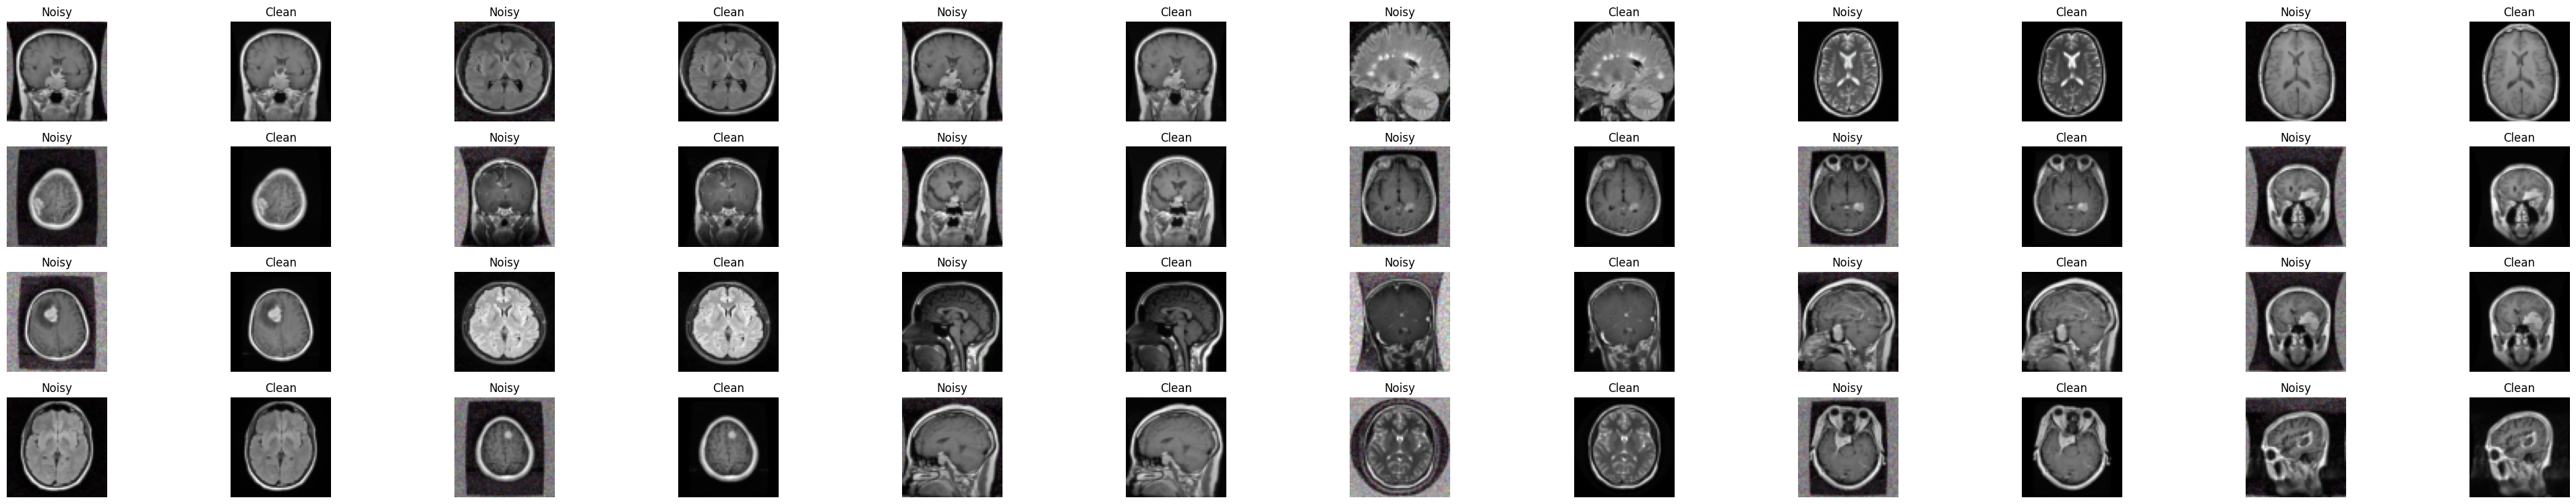

In [6]:
if __name__ == "__main__":
    print(Loader.dataset_details(),"\n\n")

    Loader.show_images()